# Capstone Project 2

## Wrangling Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning
import statsmodels.formula.api as smf
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from gensim.sklearn_api import W2VTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import nltk

In [2]:
# Load dataset
bgg_review=pd.read_csv('bgg_review.csv')
bgg_review = shuffle(bgg_review).reset_index(drop=True)

In [3]:
print(bgg_review.shape)
bgg_review

(304910, 13)


,id,name,year,min_play,max_play,min_time,max_time,min_age,category,nb_rate,username,review,rate
0,9209,Ticket to Ride,2004,2,5,30,60,8,Trains,61798,straydawg,So this isn't my favorite game... but I rated ...,9.0
1,98778,Hanabi,2010,2,5,25,25,8,Card Game,33017,Windmillfighter,Cooperative Indian poker of a sort. A unique e...,6.0
2,129622,Love Letter,2012,2,4,20,20,10,Card Game,48122,monacelli,Awww. What's not to like about this simple 14...,10.0
3,13,Catan,1995,3,4,60,120,10,Negotiation,87205,HuckmanT,"The game that got my wife and parents into ""my...",8.0
4,170216,Blood Rage,2015,2,4,60,90,14,Fantasy,26905,tgodel,Midgard has a special place on my game shelf a...,6.0
5,11,Bohnanza,1997,2,7,45,45,13,Card Game,34440,Mozart78,[size=10][u][i][b]r{Initial Thoughts}r (after ...,8.0
6,30549,Pandemic,2008,2,4,45,45,8,Medical,85707,thededalus,Thematically this is great. There is a lot of ...,9.0
7,3076,Puerto Rico,2002,3,5,90,150,12,City Building,57362,Maraud,"Not the best game of all time. Decent, but ma...",7.0
8,10547,Betrayal at House on the Hill,2004,3,6,60,60,12,Adventure,31443,GagaManMusic,Fun to play. Great theme. Just poor rules real...,8.0
9,181,Risk,1959,2,6,120,120,10,Territory Building,26737,AngelaR,Bookshelf edition.,7.0


In [4]:
# Filtering dataset by removing the NaN Values from the 'review' column
bgg_review=bgg_review[bgg_review['review'].notnull()]

In [5]:
bgg_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304864 entries, 0 to 304909
Data columns (total 13 columns):
id          304864 non-null int64
name        304864 non-null object
year        304864 non-null int64
min_play    304864 non-null int64
max_play    304864 non-null int64
min_time    304864 non-null int64
max_time    304864 non-null int64
min_age     304864 non-null int64
category    304864 non-null object
nb_rate     304864 non-null int64
username    304864 non-null object
review      304864 non-null object
rate        304864 non-null float64
dtypes: float64(1), int64(8), object(4)
memory usage: 32.6+ MB


In [6]:
# Description
n_reviews = len(bgg_review)
n_boardgames = bgg_review.name.unique().size

print("Number of reviews: {:d}".format(n_reviews))
print("Number of boardgames:  {:d}".format(n_boardgames))

Number of reviews: 304864
Number of boardgames:  50


## DataStorytelling

### Rate Histogram

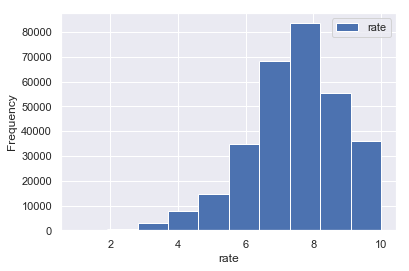

In [7]:
sns.set()
bgg_review.plot(y='rate',kind='hist')
plt.xlabel('rate')
plt.show()

### Games Dataset

In [22]:
bgg_game=bgg_review.groupby(['name','year','min_play','max_play','min_time','max_time','min_age','category',
                             'nb_rate'])[['rate']].mean()
bgg_game=bgg_game.reset_index()
print(bgg_game.shape)
bgg_game

(50, 10)


,name,year,min_play,max_play,min_time,max_time,min_age,category,nb_rate,rate
0,7 Wonders,2010,2,7,30,30,10,Ancient,70971,7.775634
1,7 Wonders Duel,2015,2,2,30,30,10,Ancient,43101,8.183666
2,Agricola,2007,1,5,30,150,12,Animals,57976,8.022455
3,Arkham Horror,2005,1,8,120,360,12,Adventure,34691,7.240667
4,Azul,2017,2,4,30,45,8,Abstract Strategy,32311,8.054097
5,Battlestar Galactica: The Board Game,2008,3,6,120,180,14,Bluffing,30364,7.783193
6,Betrayal at House on the Hill,2004,3,6,60,60,12,Adventure,31443,6.942443
7,Blood Rage,2015,2,4,60,90,14,Fantasy,26905,8.141823
8,Bohnanza,1997,2,7,45,45,13,Card Game,34440,7.222155
9,Carcassonne,2000,2,5,30,45,8,City Building,86933,7.458894


### Histogram Games Dataset

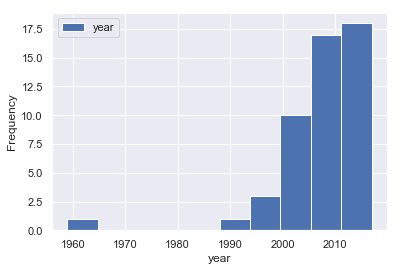

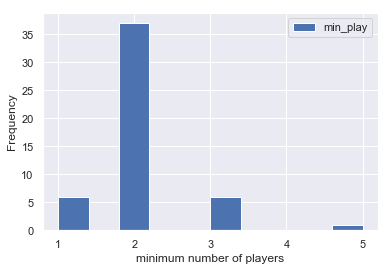

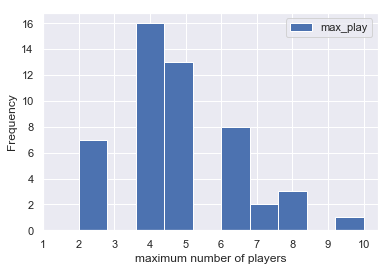

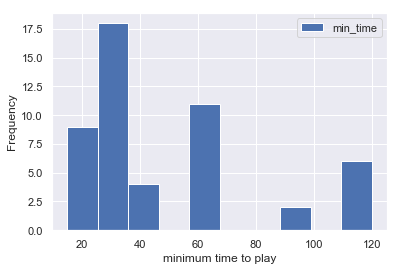

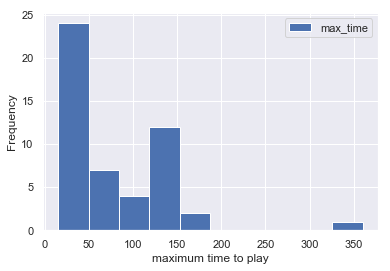

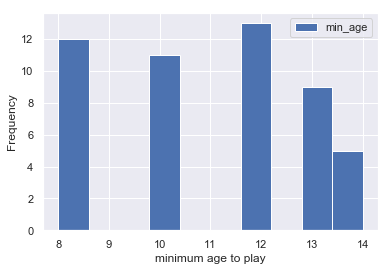

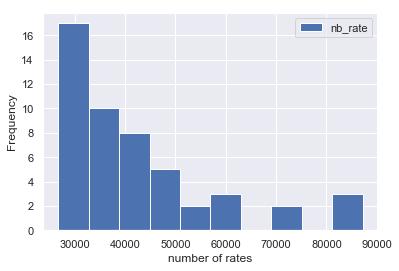

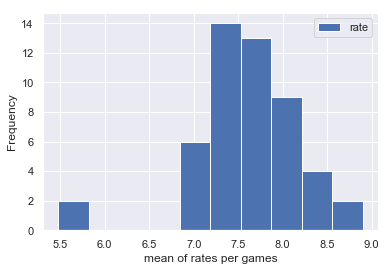

In [9]:
sns.set()
bgg_game.plot(y='year',kind='hist')
plt.xlabel('year')
plt.show()

bgg_game.plot(y='min_play',kind='hist')
plt.xlabel('minimum number of players')
Max1=bgg_game.min_play.max()
plt.xticks(range(1,Max1+1))
plt.show()

bgg_game.plot(y='max_play',kind='hist')
plt.xlabel('maximum number of players')
Max2=bgg_game.max_play.max()
plt.xticks(range(1,Max2+1))
plt.show()

bgg_game.plot(y='min_time',kind='hist')
plt.xlabel('minimum time to play')
plt.show()

bgg_game.plot(y='max_time',kind='hist')
plt.xlabel('maximum time to play')
plt.show()

bgg_game.plot(y='min_age',kind='hist')
plt.xlabel('minimum age to play')
plt.show()

bgg_game.plot(y='nb_rate',kind='hist')
plt.xlabel('number of rates')
plt.show()

bgg_game.plot(y='rate',kind='hist')
plt.xlabel('mean of rates per games')
plt.show()

### Scatter plot Games Dataset

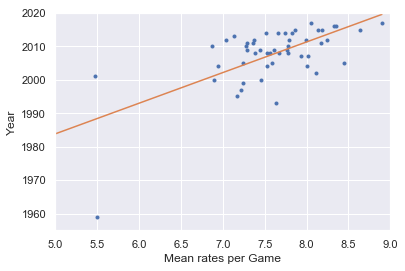

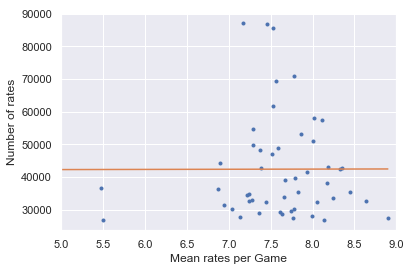

In [10]:
sns.set()
X=bgg_game.rate
Y=bgg_game.year
# Linear Regression Line
slope,intercept=np.polyfit(X,Y,1)
x=np.array([0,max(X)])
y=slope*x+intercept
# Plot
_=plt.plot(X,Y,marker='.',linestyle='none')
_=plt.plot(x,y)
_=plt.xlim(5,9)
_=plt.ylim(1955,2020)
_=plt.xlabel('Mean rates per Game')
_=plt.ylabel('Year')
plt.show()

X=bgg_game.rate
Y=bgg_game.nb_rate
# Linear Regression Line
slope,intercept=np.polyfit(X,Y,1)
x=np.array([0,max(X)])
y=slope*x+intercept
# Plot
_=plt.plot(X,Y,marker='.',linestyle='none')
_=plt.plot(x,y)
_=plt.xlim(5,9)
_=plt.xlabel('Mean rates per Game')
_=plt.ylabel('Number of rates')
plt.show()

### Statsmodel

In [11]:
results = smf.ols('rate ~ year + min_play + max_play + min_time + max_time + min_age + nb_rate', data=bgg_game).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     10.48
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.56e-07
Time:                        11:25:49   Log-Likelihood:                -21.989
No. Observations:                  50   AIC:                             59.98
Df Residuals:                      42   BIC:                             75.27
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -79.2237     14.211     -5.575      0.0

## Natural Language Processing

### Min_df Count (minimum number of documents a word must appear in for it to be included in the vocabulary)

In [7]:
vectorizer = CountVectorizer(min_df=1)
review_vec = vectorizer.fit_transform(bgg_review.review)
review_vec = review_vec.tocsc()

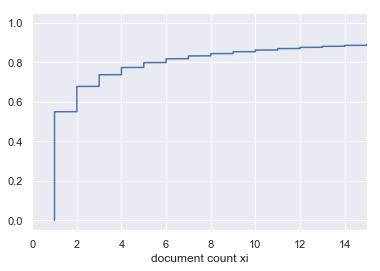

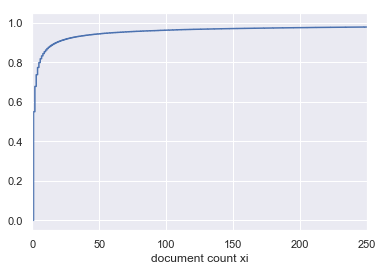

In [14]:
Sum=np.sum(review_vec,axis=0)
Sum=np.array(Sum).flatten()

n_plot=len(Sum)
x_plot=np.sort(Sum)
y_plot=np.arange(1,n_plot+1)/n_plot

sns.set()
plt.plot(x_plot,y_plot)
plt.xlabel('document count xi')
plt.xlim(0,15)
plt.show()

sns.set()
plt.plot(x_plot,y_plot)
plt.xlabel('document count xi')
plt.xlim(0,250)
plt.show()

In [15]:
Min_df=2
Max_df=200

### CountVectorizer()

In [24]:
# Data 'review' transformation
vectorizer = CountVectorizer(min_df=Min_df,stop_words='english')
review_cou = vectorizer.fit_transform(bgg_review.review)

In [25]:
# Dimensionality reduction 
svd_cou = TruncatedSVD(n_components=100, random_state=21)
review_cou_svd=svd_cou.fit_transform(review_cou)

In [26]:
# Convertion result into Dataframe
review_cou_svd_matrix=np.matrix(review_cou_svd)
review_cou_svd_df=pd.DataFrame(review_cou_svd_matrix)
print(review_cou_svd_df.shape)
review_cou_svd_df.head()

(304864, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.947798,-0.141717,-0.377152,-0.046558,-0.123295,-0.011784,-0.183432,-0.052810,-0.079480,0.027531,...,0.046796,0.059180,-0.042909,0.021850,-0.091288,0.091969,-0.000812,1.118674e-02,0.079313,-0.026616
1,3.386357,-0.513952,0.040807,-0.067477,0.495163,-0.033082,-0.829303,-0.050576,0.087947,0.242313,...,-0.050002,0.203820,0.196584,-0.179114,0.190046,0.028086,-0.212234,-3.158612e-01,0.134313,0.003308
2,0.000571,-0.000135,0.000003,0.000052,-0.000470,0.000072,0.000407,0.000105,0.000017,-0.000920,...,-0.001915,-0.003469,-0.000944,-0.001021,-0.001180,-0.001764,0.000431,-8.867593e-07,0.001166,-0.000034
3,0.370301,-0.044429,0.389426,-0.059283,-0.369238,-0.022413,0.262989,-0.924215,-0.063063,0.076708,...,0.005299,-0.031973,-0.000802,-0.027240,0.172339,0.062020,-0.125411,-9.340555e-02,0.068053,-0.004928
4,0.142035,-0.014549,0.158524,-0.025665,-0.227801,0.000431,0.178935,0.093010,0.514514,0.397376,...,0.036271,0.057477,-0.016284,0.001852,-0.030873,-0.008236,-0.035175,1.281699e-04,-0.009236,0.004283


In [27]:
# X and y creation
bgg_review_ = bgg_review.copy()
bgg_review_cou=pd.concat([bgg_review_ , review_cou_svd_df], axis=1)
bgg_review_cou=bgg_review_cou.dropna()
X_cou = bgg_review_cou.drop(['id','category','username','rate','name','review'],axis=1)
y_cou = bgg_review_cou.rate
X_train_cou,X_test_cou,y_train_cou,y_test_cou=train_test_split(X_cou,y_cou,test_size=0.2,random_state=21)

### TfidfVectorizer()

In [28]:
# Data 'review' transformation
tfidfvectorizer = TfidfVectorizer(min_df=Min_df, stop_words='english')
review_tfi = tfidfvectorizer.fit_transform(bgg_review.review)

In [29]:
# Dimensionality reduction 
svd_tfi = TruncatedSVD(n_components=100, random_state=21)
review_tfi_svd=svd_tfi.fit_transform(review_tfi)

In [30]:
# Convertion result into Dataframe
review_tfi_svd_matrix=np.matrix(review_tfi_svd)
review_tfi_svd_df=pd.DataFrame(review_tfi_svd_matrix)
print(review_tfi_svd_df.shape)
review_tfi_svd_df.head()

(304864, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.125189,-0.020861,-0.006359,-0.030061,0.026677,-0.003615,-0.003525,0.044548,-0.039581,-0.038173,...,-0.022768,0.031168,-0.067413,0.034402,-0.073834,-0.004363,-0.003453,0.074132,0.006675,0.039301
1,0.164709,-0.019608,-0.044129,-0.028756,0.008694,-0.047711,0.009000,0.010534,-0.034649,-0.027984,...,0.004092,0.015580,0.019442,-0.011655,0.018435,0.001127,-0.019847,-0.010894,0.018630,-0.040594
2,0.001381,0.000442,-0.000261,-0.000939,0.000344,-0.000127,0.000340,0.000031,-0.001047,-0.000111,...,-0.000596,0.001676,0.002194,0.000298,0.000461,0.001646,-0.003048,-0.003835,0.001048,0.002194
3,0.100619,-0.010884,-0.056591,0.086243,-0.032222,0.007550,-0.026496,0.029149,-0.055194,-0.032726,...,-0.032127,0.003808,-0.027921,0.008442,0.010243,-0.048162,0.000597,-0.047637,-0.014150,0.003970
4,0.064370,0.010680,-0.104618,-0.068240,-0.113650,0.086216,-0.190306,-0.009948,0.101679,0.048704,...,-0.000275,0.000431,-0.012360,0.001989,-0.011630,-0.000823,-0.000303,0.001710,-0.003592,0.012517


In [31]:
# X and y creation
bgg_review_ = bgg_review.copy()
bgg_review_tfi=pd.concat([bgg_review_ , review_tfi_svd_df], axis=1)
bgg_review_tfi=bgg_review_tfi.dropna()
X_tfi = bgg_review_tfi.drop(['id','category','username','rate','name','review'],axis=1)
y_tfi = bgg_review_tfi.rate
X_train_tfi,X_test_tfi,y_train_tfi,y_test_tfi = train_test_split(X_tfi,y_tfi,test_size=0.2,random_state=21)

### Word2Vec()

In [7]:
# Data preprocessing
nltk.download('punkt') 
df_tk=bgg_review.copy()
df_tk['tokenized_sents'] = df_tk.apply(lambda row: nltk.word_tokenize(row['review']), axis=1)
df_tk.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Diane\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


,id,name,year,min_play,max_play,min_time,max_time,min_age,category,nb_rate,username,review,rate,tokenized_sents
0,9209,Ticket to Ride,2004,2,5,30,60,8,Trains,61798,straydawg,So this isn't my favorite game... but I rated ...,9.0,"[So, this, is, n't, my, favorite, game, ..., b..."
1,98778,Hanabi,2010,2,5,25,25,8,Card Game,33017,Windmillfighter,Cooperative Indian poker of a sort. A unique e...,6.0,"[Cooperative, Indian, poker, of, a, sort, ., A..."
2,129622,Love Letter,2012,2,4,20,20,10,Card Game,48122,monacelli,Awww. What's not to like about this simple 14...,10.0,"[Awww, ., What, 's, not, to, like, about, this..."
3,13,Catan,1995,3,4,60,120,10,Negotiation,87205,HuckmanT,"The game that got my wife and parents into ""my...",8.0,"[The, game, that, got, my, wife, and, parents,..."
4,170216,Blood Rage,2015,2,4,60,90,14,Fantasy,26905,tgodel,Midgard has a special place on my game shelf a...,6.0,"[Midgard, has, a, special, place, on, my, game..."


In [11]:
# Data 'review' transformation
model = Word2Vec(df_tk.tokenized_sents,min_count=2,size= 100)

C:\Users\Diane\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


KeyboardInterrupt: 

In [ ]:
# Convertion result into Dataframe
review_wor_matrix=np.matrix(review_wor)
review_wor_df=pd.DataFrame(review_wor_matrix)
print(review_wor_df.shape)
review_wor_df.head()

In [ ]:
# X and y creation
bgg_review_wor = bgg_review.copy()
bgg_review_wor['review_wor'] = review_wor
X_wor = bgg_review_wor.drop(['id','category','username','rate','name','review'],axis=1)
y_wor = bgg_review_wor.rate
X_train_wor , X_test_wor , y_train_wor , y_test_wor = train_test_split(X_wor , y_wor , test_size=0.2 , random_state=21)

## Machine Learning

### Random Forest
- CountVectorizer()

In [17]:
param_grid={'max_depth':np.arange(1,10)}
regr_cou=RandomForestRegressor(random_state=21)
regr_cou_cv=GridSearchCV(regr_cou,param_grid,cv=5)
regr_cou_cv.fit(X_train_cou,y_train_cou)
print('Best parameter:',regr_cou_cv.best_params_)
print('Best score:',regr_cou_cv.best_score_)

C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

Best parameter: {'max_depth': 9}
Best score: 0.14455087214875834


In [19]:
best_max_depth_cou=regr_cou_cv.best_params_
regr_cou=RandomForestRegressor(max_depth=best_max_depth_cou, random_state=21)
# Cross Validation
cv_result_cou_rf=cross_val_score(regr_cou,X_train_cou,y_train_cou,cv=5)
# Score
print(cv_result_cou_rf)
print('CV result mean (CountVectorizer_RandomForest) =',np.mean(cv_result_cou_rf))

C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

[0.14723551 0.14357053 0.14547414 0.14320625 0.14326791]
CV result mean (CountVectorizer_RandomForest) = 0.1445508668875809


- TfidfVectorizer()

In [29]:
param_grid={'max_depth':np.arange(1,10)}
regr_tfi=RandomForestRegressor(random_state=21)
regr_tfi_cv=GridSearchCV(regr_tfi,param_grid,cv=5)
regr_tfi_cv.fit(X_train_tfi,y_train_tfi)
print('Best parameter:',regr_tfi_cv.best_params_)
print('Best score:',regr_tfi_cv.best_score_)

C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

Best parameter: {'max_depth': 9}
Best score: 0.14453158335128993


In [31]:
best_max_depth_tfi=regr_tfi_cv.best_params_
regr_tfi=RandomForestRegressor(max_depth=best_max_depth_tfi, random_state=21)
# Cross Validation
cv_result_tfi_rf=cross_val_score(regr_tfi,X_train_tfi,y_train_tfi,cv=5)
# Score
print(cv_result_tfi_rf)
print('CV result mean (TfidfVectorizer_RandomForest) =',np.mean(cv_result_tfi_rf))

C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

[0.14643925 0.14346198 0.14594262 0.14369841 0.14311563]
CV result mean (TfidfVectorizer_RandomForest) = 0.14453157754473794


- Word2Vec()

### Support Vector Regression
- CountVectorizer()

In [ ]:
param_grid={'epsilon':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
clf_cou=SVR()
clf_cou_cv=GridSearchCV(clf_cou,param_grid,cv=5)
clf_cou_cv.fit(X_train_cou,y_train_cou)
print('Best parameter:',clf_cou_cv.best_params_)
print('Best score:',clf_cou_cv.best_score_)

In [ ]:
best_epsilon_cou=clf_cou_cv.best_params_
clf_cou = SVR(epsilon=best_epsilon_cou)
# Cross Validation
cv_result_cou_SVR=cross_val_score(clf_cou,X_train_cou,y_train_cou,cv=5)
# Score
print(cv_result_cou_SVR)
print('CV result mean (CountVectorizer_SVR) =',np.mean(cv_result_cou_SVR))

- TfidfVectorizer()

In [ ]:
param_grid={'epsilon':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
clf_tfi=SVR()
clf_tfi_cv=GridSearchCV(clf_tfi,param_grid,cv=5)
clf_tfi_cv.fit(X_train_tfi,y_train_tfi)
print('Best parameter:',clf_tfi_cv.best_params_)
print('Best score:',clf_tfi_cv.best_score_)

In [ ]:
best_epsilon_tfi=clf_tfi_cv.best_params_
clf_tfi = SVR(epsilon=best_epsilon_tfi)
# Cross Validation
cv_result_tfi_SVR=cross_val_score(clf_tfi,X_train_tfi,y_train_tfi,cv=5)
# Score
print(cv_result_tfi_SVR)
print('CV result mean (TfidfVectorizer_SVR) =',np.mean(cv_result_tfi_SVR))

- Word2Vec()

### Pipeline - Random Forest
- CountVectorizer()

In [16]:
# X & y creation
X = bgg_review.drop(['id','category','username','rate','name'],axis=1)
y = bgg_review.rate
# train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=21)

In [71]:
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.field]]
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

In [74]:
classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('review')),
            ('CountVectorizer', CountVectorizer(min_df=Min_df,max_df=Max_df,stop_words='english')),
            ('svd', TruncatedSVD(n_components=100,random_state=21)),])),
        ('features', NumberSelector([['year','min_play','max_play','min_time','max_time','min_age','nb_rate']])),])),
    ('clf', RandomForestRegressor(max_depth=9, random_state=21)),])
cv_result_cou_RF_pip=cross_val_score(classifier,X_train,y_train,cv=5)
# Score
print(cv_result_cou_RF_pip)
print('CV result mean (CountVectorizer_RadomForest_Pipeline) =',np.mean(cv_result_cou_RF_pip))

ValueError: Buffer has wrong number of dimensions (expected 1, got 3)

- TfidfVectorizer()

- Word2Vec()

### Pipeline - Support Vector Regression
- CountVectorizer()

- TfidfVectorizer()

- Word2Vec()